## Projects in Advanced Machine Learning
### GR5074
### Homework 2
### Cecilia Cabello Esquer

In [0]:
# Load libraries and then download data
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3

In [0]:
#!unzip brain_tumor_dataset.zip  

In [0]:
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4])

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y98.JPG', 'brain_tumor_dataset/yes/Y76.jpg', 'brain_tumor_dataset/yes/Y38.jpg', 'brain_tumor_dataset/yes/Y253.JPG', 'brain_tumor_dataset/yes/Y108.jpg', 'brain_tumor_dataset/yes/Y11.jpg', 'brain_tumor_dataset/yes/Y20.jpg', 'brain_tumor_dataset/yes/Y82.jpg', 'brain_tumor_dataset/yes/Y153.jpg', 'brain_tumor_dataset/yes/Y3.jpg', 'brain_tumor_dataset/yes/Y44.JPG', 'brain_tumor_dataset/yes/Y257.jpg', 'brain_tumor_dataset/yes/Y29.jpg', 'brain_tumor_dataset/yes/Y22.jpg', 'brain_tumor_dataset/yes/Y168.jpg', 'brain_tumor_dataset/yes/Y14.jpg', 'brain_tumor_dataset/yes/Y112.JPG', 'brain_tumor_dataset/yes/Y113.JPG', 'brain_tumor_dataset/yes/Y103.jpg', 'brain_tumor_dataset/yes/Y34.jpg', 'brain_tumor_dataset/yes/Y104.jpg', 'brain_tumor_dataset/yes/Y249.JPG', 'brain_tumor_dataset/yes/Y1.jpg', 'brain_tumor_dataset/yes/Y120.JPG', 'brain_tumor_dataset/yes/Y187.jpg', 'brain_tumor_dataset/yes/Y156.JPG', 'brain_tumor_dataset/yes/Y116.J

In [0]:
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224))
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) 
        img=img.reshape((224,224,3)) 
        return img

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

X= np.array(preprocessed_image_data)

Using TensorFlow backend.


In [0]:
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))

y_labels = yes+no

print(len(y_labels) )

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


**1.Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.**

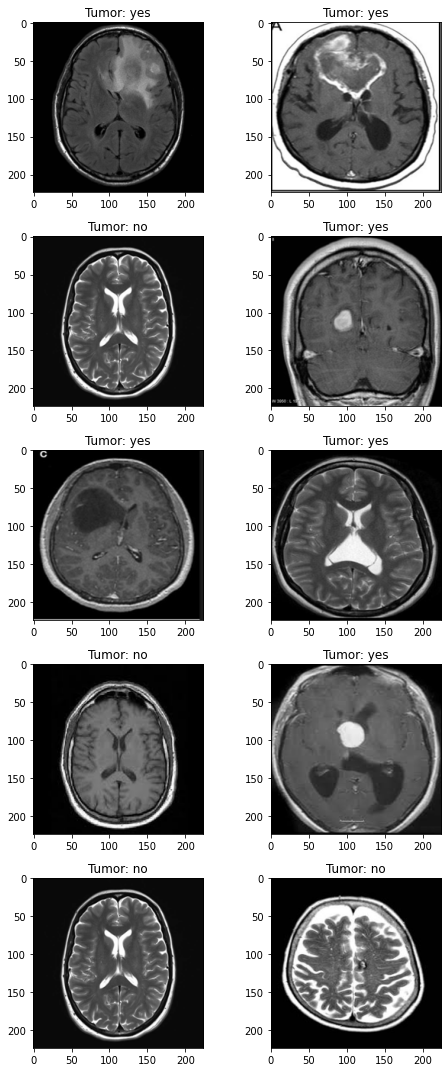

In [0]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

**2.Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.**
   

Explanation in the final report below.

**3.Run at least three prediction models to try to predict brain tumor MRI images well.**

* Use transfer learning for at least one of these models
* Discuss which models performed better and point out relevant hyper-parameter values for successful models.


In [0]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=4)

y_train 

,no,yes
101,0,1
46,0,1
225,1,0
116,0,1
214,1,0
...,...,...
129,0,1
197,1,0
183,1,0
174,1,0


### Model 1

In [0]:
# Let's set a baseline plain vanilla network model to use as a baseline for convnet models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      modelbase = VGG19(weights='imagenet', include_top=False, input_shape = (224,224,3))

      model = Sequential([modelbase])
      
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 

  
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.6485
Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to best_model.h5
7/7 [==============================] - 2s 285ms/step - loss: 0.6604 - accuracy: 0.6485 - val_loss: 0.6238 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.6188
Epoch 00002: val_accuracy did not improve from 0.66667
7/7 [==============================] - 2s 233ms/step - loss: 0.6399 - accuracy: 0.6188 - val_loss: 0.6089 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.7277
Epoch 00003: val_accuracy did not improve from 0.66667

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 2s 232ms/step - loss: 0.6091 - accuracy: 0.7277 - val_loss: 0.5867 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/5
7/7 [========================

In [0]:
model.history.epoch

[0, 1, 2, 3, 4]

In [0]:
#### como ver el accurancy
from sklearn.metrics import accuracy_score

def predict_classes(x):
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions=model.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

print(accuracy_score(y_test_labels, predicted_labels))

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes']
0.7450980392156863


### Model 2

In [0]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      modelbase = VGG19(weights='imagenet', include_top=False, input_shape = (224,224,3))

      model = Sequential([modelbase])

      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 

  
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 25, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.5990
Epoch 00001: val_accuracy improved from -inf to 0.68627, saving model to best_model.h5
7/7 [==============================] - 2s 284ms/step - loss: 0.6440 - accuracy: 0.5990 - val_loss: 0.6019 - val_accuracy: 0.6863 - lr: 0.0010
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.6584
Epoch 00002: val_accuracy improved from 0.68627 to 0.74510, saving model to best_model.h5
7/7 [==============================] - 2s 328ms/step - loss: 0.5796 - accuracy: 0.6584 - val_loss: 0.5878 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.7921
Epoch 00003: val_accuracy did not improve from 0.74510
7/7 [==============================] - 2s 231ms/step - loss: 0.5311 - accuracy: 0.7921 - val_loss: 0.5460 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 

In [0]:
model.history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [0]:
## como ver el accurancy
from sklearn.metrics import accuracy_score

def predict_classes(x):
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions=model.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

print(accuracy_score(y_test_labels, predicted_labels))

[1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0
 0 1 1 1 1 1 1 1 0 0 1 1 0 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes']
0.8235294117647058


### Model 3

In [0]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 25, verbose=1,validation_data=(X_test,y_test))

Epoch 1/25
7/7 [==============================] - 1s 144ms/step - loss: 0.6439 - accuracy: 0.5941 - val_loss: 0.6026 - val_accuracy: 0.6667
Epoch 2/25
7/7 [==============================] - 1s 125ms/step - loss: 0.5862 - accuracy: 0.6485 - val_loss: 0.6375 - val_accuracy: 0.6667
Epoch 3/25
7/7 [==============================] - 1s 126ms/step - loss: 0.5591 - accuracy: 0.7178 - val_loss: 0.5526 - val_accuracy: 0.7255
Epoch 4/25
7/7 [==============================] - 1s 125ms/step - loss: 0.5464 - accuracy: 0.7426 - val_loss: 0.6409 - val_accuracy: 0.6078
Epoch 5/25
7/7 [==============================] - 1s 126ms/step - loss: 0.5242 - accuracy: 0.7525 - val_loss: 0.5359 - val_accuracy: 0.7451
Epoch 6/25
7/7 [==============================] - 1s 127ms/step - loss: 0.5184 - accuracy: 0.7921 - val_loss: 0.5239 - val_accuracy: 0.7647
Epoch 7/25
7/7 [==============================] - 1s 125ms/step - loss: 0.4979 - accuracy: 0.8119 - val_loss: 0.5660 - val_accuracy: 0.6863
Epoch 8/25
7/7 [====

In [0]:
model.history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [0]:
## accurancy
from sklearn.metrics import accuracy_score

def predict_classes(x):
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions=model.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

print(accuracy_score(y_test_labels, predicted_labels))

[1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0
 0 1 1 1 1 1 1 0 0 0 1 1 0 1]
['yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes']
0.7647058823529411


In [0]:
# modeleval function
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [0]:
y_test_labels=y_test.idxmax(axis=1) 
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")
modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


modelevalobject


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.823529,0.791458,0.811776,0.779412,0,0,0,0


In [0]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

In [0]:
import os
os.environ['TF_KERAS'] = '1'
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

**4.Submit your best model to the leader board for the Brain Tumor Diagnostic AI Model Share competition.**

In [0]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=2b059792d5c4eea1d7ee9f7e2fd06eb1ef39bb2d3460b0c620ca8082b42f51cd
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "ccabelloe"
password = "machinelearning"

model_filepath="my_model.onnx"

model=model

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [0]:
# Submit your model using submit_model() function
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,modelobject=model,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")


"my_model.onnx" has been loaded to version 41 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


**5.Import the best model from the leader board (whatever the best model is after your final submission)**

* Note: Import the model's config and it's optimization config.
* Visualize the model's structure using tf.kera's model.summary() 
* Explain how the model's structure is different from your best model.
* Explain how the model's optimization approach is different from your best model


In [0]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
31,0.823529,0.791458,0.811776,0.779412,0,0,0,0,ccabelloe,40,8.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
32,0.823529,0.791458,0.811776,0.779412,0,0,0,0,ccabelloe,41,8.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
30,0.803922,0.802019,0.805643,0.800926,0,0,0,0,XU,39,8.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


In [0]:
# Import and print model details from leaderboard
model_config= leaderboard.loc[0,'model_config'] 
model_optim_config= leaderboard.loc[0,'model_optim_config'] 

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      name: dense
      trainable: true
      units: 64
      use_bias: true
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}

In [0]:
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
dense_2 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6422530   
Total params: 6,431,106
Trainable params: 6,431,106
Non-trainable params: 0
_________________________________________________________________


**6.Fit the best model from the leader board to training data and evaluate it on test data to complete your report.**

In [61]:
opt=SGD(lr=.001)

model = Sequential()
model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax')) 
                                            
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 5, verbose=1,validation_data=(X_test,y_test))

ERROR! Session/line number was not unique in database. History logging moved to new session 63
Epoch 1/5
7/7 [==============================] - 1s 145ms/step - loss: 0.6414 - accuracy: 0.5792 - val_loss: 0.6059 - val_accuracy: 0.6667
Epoch 2/5
7/7 [==============================] - 1s 126ms/step - loss: 0.6139 - accuracy: 0.5990 - val_loss: 0.5915 - val_accuracy: 0.6863
Epoch 3/5
7/7 [==============================] - 1s 126ms/step - loss: 0.5834 - accuracy: 0.6485 - val_loss: 0.5788 - val_accuracy: 0.6667
Epoch 4/5
7/7 [==============================] - 1s 125ms/step - loss: 0.5765 - accuracy: 0.6782 - val_loss: 0.5609 - val_accuracy: 0.7059
Epoch 5/5
7/7 [==============================] - 1s 124ms/step - loss: 0.5545 - accuracy: 0.7178 - val_loss: 0.5519 - val_accuracy: 0.7451


### Report

Having the ability to dectect the existance of brain tumors, using only magnetic resonance imaging (MRIs) could minimize the diagnosis time, while improving the efficiency of set diagnosis. Although, such prediction models might not be enough to determine the existance of a life altering disease (given their accurancy scores), these do contribute greatly to the optimization of the whole diagnosis process, and could even be included as another verification layer or step. 
  Such a model would benefit mostly those involved in the diagnosis process, particularly doctors, as it would shorten the response time for patients, result in higher levels of certainty, and might even automatize a part of an every day task for many health care workers. 

My first model held an accurancy of over 74%, remaining relatively simple as it had 3 layers with no dropout nor other regularization form, however it optimized using standard stochastic gradient descent with a learning rate of 0.001, and most importantly it took as base a VGG19 model. The second model, also a VGG19, was even more simple as it mantained the exact same specifications as the first one, but it added one less layer, but increasing the number of epochs from 5 to 25. This resulted in an increase in the accurancy score to 82%. Making it the best model out of my three. My final model was a more simple approach as it was a neural network with no regularization method, two layers, 25 epochs, and no checkout. It obtained a 76% accuracy score. Having acknowledge that we could assume the simpler the model the better thee scores, for the available data. 

The best overall model maintains the idea that simpler is better in this case, as it has three layers and uses no VGG19, in contrast, to my first two models and my best performing model. Some similarities between my best model and that the one with the highest score on the leaderboard is that they both have two layers and both use standard stochastic gradient descent with a learning rate of 0.001. 

Once the my model is fit to the training data we can see that the new accurancy scores is loweer tha before.



**Link repo:** https://github.com/cecicabello/HW2.git